## 3D Reflectivity Cross-Section Plot for derived dBZ from WRF Simulations. 

**Test plots either using the $\sigma$-level or the geo-height interpolated level.**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211018**

In [462]:
import sys
from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, interplevel, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair, WrfProj)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors


**Set input files paths and names:**

In [463]:
def set_input_names(file_date):

    file_path_1 = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1 
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

In [464]:
## Set wrf simulation type:
wrf_sim_type = 'CTRL3D'

## Set date time:
case_date_time = dt.datetime(2011,4,27) 
# case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/2011/wrf3d_d01_CTRL_dbz_20110427.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2011/wrf3d_d01_CTRL_Z_20110427.nc'}


**Load the data information from INVARIANT data:**

In [465]:
# ds_wrf_invariant = xr.open_dataset('/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/INVARIANT/RALconus4km_wrf_constants.nc')
# da_wrf_terrain = ds_wrf_invariant.HGT.isel(Time=0)
# ds_wrf_invariant

## Load the terrain data:
ter = getvar( Dataset('/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/INVARIANT/RALconus4km_wrf_constants.nc')
            , 'HGT'
            , timeidx=0
            , meta=False)


**Open data on sigma level:**

In [466]:
## Set hour:
## 0:00, 1:03, 2:06, 3:09, 4:12, 5:15, 6:18, 7:21
time_hour_idx = 4

## Set sigma level index:
sigma_lev = 12 # number in levels.

## Get dBZ and the geopotential height:
ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=time_hour_idx)

data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=time_hour_idx, meta=False), 0)

dbz_sigmalev = da_wrf_dbz[sigma_lev,:,:]
geoH_sigmalev = data_wrf_z_unstag[sigma_lev,:,:]

**Deploy wrf.interplevel to get data on interpolated level:**

In [467]:
## Set interpolation height:
interp_vertical_lev = 3000 # meter in height.

## dBZ Interpolation directly:
# dbz_lev = interplevel(da_wrf_dbz, data_wrf_z_unstag, interp_vertical_lev)

## (dB)Z interpolation linearly:
da_wrf_linearZ = 10**(da_wrf_dbz/10.) # Use linear Z for interpolation
dbz_lev = interplevel(da_wrf_linearZ, data_wrf_z_unstag, interp_vertical_lev)
dbz_lev = 10.0 * np.log10(dbz_lev) # Convert back to dBz after interpolation

dbz_lev = dbz_lev.assign_attrs(vert_units='m')


### Cross-section:

**Set the LON/LAT for cross-section Start/End points:**

In [468]:
## Specify the x, y for cross-section for 9/13 case:
# xsec1_LON = [-108, -100]
# xsec1_LAT = [42, 35]
# xsec2_LON = [-107, -101]
# xsec2_LAT = [32.5, 41]

## Specify the x, y for cross-section for 4/27 case:
xsec1_LON = [-92.4, -89.0]
xsec1_LAT = [38, 34]
xsec2_LON = [-91.8, -88.2]
xsec2_LAT = [34, 38]

# xsec2_LON = [-92.4, -89.0]
# xsec2_LAT = [38, 34]
# xsec3_LON = [-92.2, -88.8]
# xsec3_LAT = [38, 34]
# xsec4_LON = [-92.0, -88.6]
# xsec4_LAT = [38, 34]

xsec0_LON = [-91.6, -88.0]
xsec0_LAT = [34, 38]
xsec3_LON = [-92.0, -88.4]
xsec3_LAT = [34, 38]
xsec4_LON = [-92.2, -88.6]
xsec4_LAT = [34, 38]

# ## Define the cross-section start and end points from LAT, LON:
# cross_start = CoordPair(lat=xsec_LAT[0], lon=xsec_LON[0])
# cross_end = CoordPair(lat=xsec_LAT[1], lon=-xsec_LON[1])

**Function: Find the nearest grid locations to the desired point:**

In [469]:
def xy_point_loc_from_grid_latlon(grid_lon, grid_lat, lon, lat):
    abslon = np.abs(grid_lon-lon)
    abslat = np.abs(grid_lat-lat)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))
    
    return xloc, yloc

**Define the cross-section start and end points to nearest X, Y locations:**

In [470]:
xsec_LON = xsec1_LON
xsec_LAT = xsec1_LAT

loc_start = xy_point_loc_from_grid_latlon(dbz_lev.XLONG.data, dbz_lev.XLAT.data, xsec_LON[0], xsec_LAT[0])
loc_end = xy_point_loc_from_grid_latlon(dbz_lev.XLONG.data, dbz_lev.XLAT.data, xsec_LON[1], xsec_LAT[1])

cross_start = CoordPair(x=loc_start[0], y=loc_start[1])
cross_end = CoordPair(x=loc_end[0], y=loc_end[1])

# print(cross_start)

**Compute the vertical cross-section (from X, Y):**

In [471]:
# wrf_meta = Dataset('/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/INVARIANT/RALconus4km_wrf_constants.nc')

dbz_xsec = vertcross( da_wrf_linearZ # Use linear Z for interpolation
                      # da_wrf_dbz
                    , data_wrf_z_unstag
                    # , wrfin=wrf_meta
                    # , timeidx=time_hour_idx
                    , start_point=cross_start
                    , end_point=cross_end
                    # , projection=WrfProj.cartopy()
                    # , ll_point=CoordPair(lat=18.1362915, lon=-139.05480957)
                    # , latlon=True
                    # , meta=False
                    )

dbz_xsec = 10.0 * np.log10(dbz_xsec) # Convert back to dBZ after interpolation


**Get the terrain heights along the cross section line:**

In [472]:
ter_line = interpline( ter
                     # , wrfin=wrf_file
                     , start_point=cross_start
                     , end_point=cross_end
                     )

**Get the geo-heights at the sigma-level along the cross section line:**

In [473]:
sigma_line = interpline( geoH_sigmalev
                       , start_point=cross_start
                       , end_point=cross_end
                        )

In [474]:
# print(loc_start, loc_end)
# da_wrf_linearZ
# wrf_meta
# dbz_xsec

### Test plot:

**Set colorbars:**

In [475]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

**Function: Creating new map:**

In [476]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    # ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    #ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    ax.set_extent([-96, -84, 33, 41], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 2
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Plot: Map**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


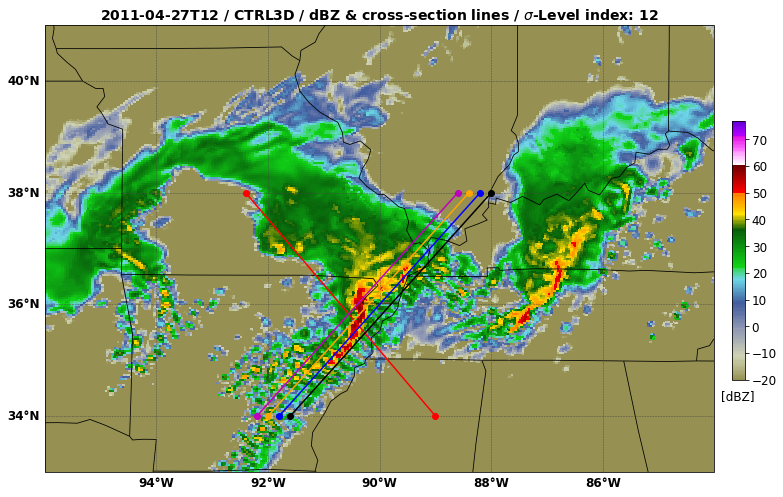

In [477]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

# plotting_var = dbz_lev.data
plotting_var = dbz_sigmalev.data

plotting_lon = dbz_lev.XLONG
plotting_lat = dbz_lev.XLAT


## CWB colorbar:
# cf1 = ax1.contourf(plotting_lon, plotting_lat, plotting_var, 23, levels=clevs, colors=ccols)

## NWS colorbar:
cf1 = ax1.pcolormesh(plotting_lon, plotting_lat, plotting_var, cmap=ref_cmap, norm=ref_norm, shading='auto')

## Plot cross-section lines:
xsec_line1_color = 'red'
xsec_line2_color = 'blue'

plt.plot( xsec1_LON, xsec1_LAT
        , color=xsec_line1_color
        , marker='o'
        , markersize=6
        # , linewidth=1.0
        # , linestyle='--'
        )
plt.plot( xsec2_LON, xsec2_LAT
        , color=xsec_line2_color
        , marker='o'
        , markersize=6
        # , linewidth=1.0
        # , linestyle='--'
        )
plt.plot( xsec3_LON, xsec3_LAT
        , color='orange'
        , marker='o'
        , markersize=6
        # , linewidth=1.0
        # , linestyle='--'
        )
plt.plot( xsec4_LON, xsec4_LAT
        , color='m'
        , marker='o'
        , markersize=6
        # , linewidth=1.0
        # , linestyle='--'
        )
plt.plot( xsec0_LON, xsec0_LAT
        , color='k'
        , marker='o'
        , markersize=6
        # , linewidth=1.0
        # , linestyle='--'
        )
# plt.plot( [ dbz_lev.XLONG[loc_start[0], loc_start[1]], dbz_lev.XLONG[loc_end[0], loc_end[1]] ]
#         , [ dbz_lev.XLAT[loc_start[0], loc_start[1]], dbz_lev.XLAT[loc_end[0], loc_end[1]] ]
#         , color='k'
#         , marker='o'
#         , markersize=6
#         # , linewidth=1.0
#         # , linestyle='--'
#         )

cf1_title = plt.title( np.datetime_as_string(dbz_lev.Time.data, unit='h')
                     + ' / '
                     + wrf_sim_type + ' / '
                     + 'dBZ & cross-section lines / '
                     # + 'z=' + str(interp_vertical_lev) + dbz_lev.vert_units 
                     + '$\sigma$-Level index: ' + str(sigma_lev)
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz_xline.png', 
            bbox_inches='tight', 
            dpi=300)


**Function: Creating new cross-section:**

In [478]:
def new_xsec(fig):
    
    # axis_color = xsec_line2_color
    
    ax = plt.axes()
    
    ax.set_xticks([0,dbz_xsec.xy_loc.size-1])
    ax.set_xticklabels( # ['SW', 'NE'] 
                        ['NW', 'SE']
                      , fontsize=14
                      , fontweight='bold'
                      # , color=axis_color
                      , rotation = 45
                      , ha='right' # horizontalalignment
                      )
    
    ax.set_ylim([0, 14000])
    ax.set_yticks(np.arange(0, 14001, 2000))
    ax.set_yticklabels( np.arange(0, 14001, 2000)/1000
                      , fontsize=12
                      , fontweight='bold'
                      )
    
    # ax.spines['bottom'].set_color(axis_color)
    # ax.spines['bottom'].set_linewidth(2.5)
    
    return ax

**Plot: Cross-section:**

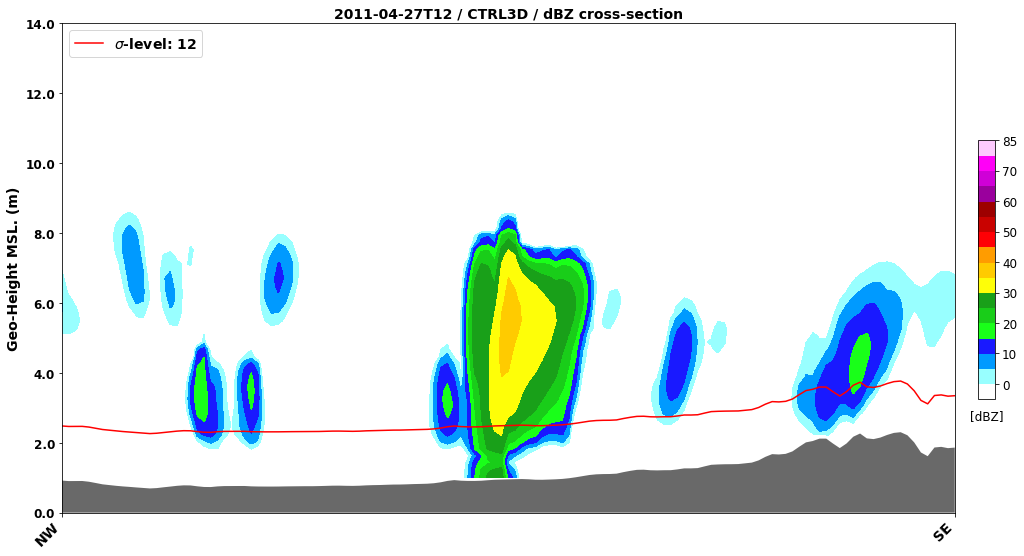

In [479]:
fig_xsec = plt.figure(figsize=(16,9))
ax_xsec = new_xsec(fig_xsec)

plotting_var = dbz_xsec.data
plotting_x = np.arange(dbz_xsec.xy_loc.size)
plotting_y = dbz_xsec.vertical.data

## CWB colorbar (xarray plot):
# cf2 = dbz_xsec.plot.contourf( vmin=0, vmax=80, levels=clevs, colors=ccols)

## CWB colorbar:
cf2 = ax_xsec.contourf( plotting_x, plotting_y, plotting_var
                      , levels=clevs
                      , colors=ccols
                      # , vmin=0
                      # , vmax=20
                      )

## NWS colorbar:
# cf2 = ax_xsec.pcolormesh( plotting_x, plotting_y, plotting_var
#                         , cmap=ref_cmap
#                         , norm=ref_norm
#                         , shading='auto'
#                         )

plt.ylabel('Geo-Height MSL. (m)', {'size': 14, 'weight': 'bold'})

## Plot the sigmal level line:
xsec_color = xsec_line1_color

sigma_lev_h = ax_xsec.plot( plotting_x, sigma_line
                          , color=xsec_color)

ax_xsec.legend( sigma_lev_h, ['$\sigma$-level: ' + str(sigma_lev)]
              , loc='upper left'
              # , fontsize=14
              , prop={'size':14, 'weight':'bold'}
              )

## Fill in the mountain terrain:
ter_fill = ax_xsec.fill_between(plotting_x, 0, ter_line,
                                facecolor='dimgrey')

cf2_title = plt.title( np.datetime_as_string(dbz_lev.Time.data, unit='h')
                     + ' / '
                     + wrf_sim_type
                     + ' / dBZ cross-section'
                     # + 'z=' + str(interp_vertical_lev) + dbz_lev.vert_units 
                     # + ' / $\sigma$-Level index: ' + str(sigma_lev)
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig_xsec.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig_xsec.colorbar(cf2, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz_xsec.png', 
            bbox_inches='tight', 
            dpi=300)



In [480]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
